### Importing Libraries

In [18]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
tf.random.set_seed(42)

### Constants

In [19]:
img_height, img_width = 128, 128
batch_size = 32
num_classes = 124
data_dir = os.path.join(os.getcwd(), "gei/")

### Training Data Augmentation

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.15,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    brightness_range=[0.8, 1.2],
    channel_shift_range=10,
    zoom_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [22]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42,
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42,
)

Found 11656 images belonging to 124 classes.
Found 1984 images belonging to 124 classes.


### Load pre-trained ResNet50 without top layers

In [23]:
base_model = ResNet50(
    weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3)
)

### Add custom classification layers

In [24]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.003))(x)
predictions = Dense(num_classes, activation='linear',
                    kernel_regularizer=l2(0.003))(x)

### Create the model

In [25]:
model = Model(inputs=base_model.input, outputs=predictions)

### Fine Tune the layers

In [26]:
for layer in model.layers:
    layer.trainable = True

### Compile the model

In [27]:
model.compile(
    optimizer=RMSprop(
        learning_rate=1e-4,
        rho=0.9,
        momentum=0.0,
        epsilon=1e-07,
        centered=False,
        name="RMSprop",
    ),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

### Train the model

In [28]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

Epoch 1/50
365/365 [==============================] - 235s 618ms/step - loss: 12.8375 - accuracy: 0.0148 - val_loss: 12.4129 - val_accuracy: 0.0081
Epoch 2/50
365/365 [==============================] - 224s 614ms/step - loss: 11.8074 - accuracy: 0.0457 - val_loss: 12.0342 - val_accuracy: 0.0060
Epoch 3/50
365/365 [==============================] - 222s 607ms/step - loss: 10.7754 - accuracy: 0.1006 - val_loss: 10.6985 - val_accuracy: 0.0832
Epoch 4/50
365/365 [==============================] - 222s 608ms/step - loss: 9.6879 - accuracy: 0.1966 - val_loss: 9.0867 - val_accuracy: 0.2807
Epoch 5/50
365/365 [==============================] - 225s 616ms/step - loss: 8.7261 - accuracy: 0.3000 - val_loss: 8.6608 - val_accuracy: 0.3090
Epoch 6/50
365/365 [==============================] - 223s 611ms/step - loss: 7.9081 - accuracy: 0.3933 - val_loss: 8.2698 - val_accuracy: 0.3422
Epoch 7/50
365/365 [==============================] - 219s 600ms/step - loss: 7.2100 - accuracy: 0.4697 - val_loss: 7.

### Evaluate model on training set

In [29]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training accuracy: {train_accuracy}")

365/365 [==============================] - 98s 269ms/step - loss: 0.7832 - accuracy: 0.9401
Training accuracy: 0.9401167035102844


### Evaluate model on testing set

In [30]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Testing accuracy: {test_accuracy}")

62/62 [==============================] - 11s 181ms/step - loss: 1.6432 - accuracy: 0.7394
Testing accuracy: 0.7394153475761414


### Save the model

In [31]:
model.save('gait_resnet50.h5')

### Model Summary

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Plot Training & Validation Accuracy

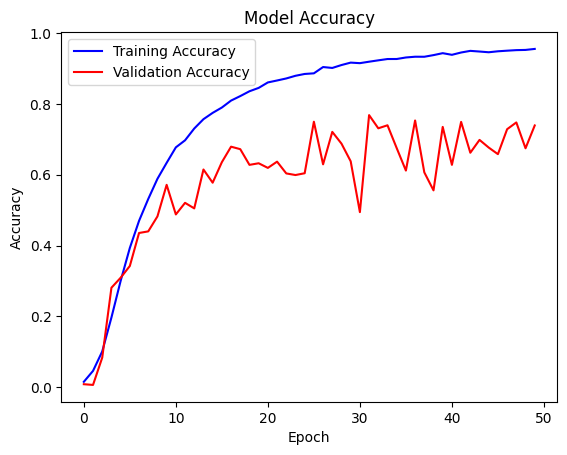

In [33]:
plt.plot(history.history['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

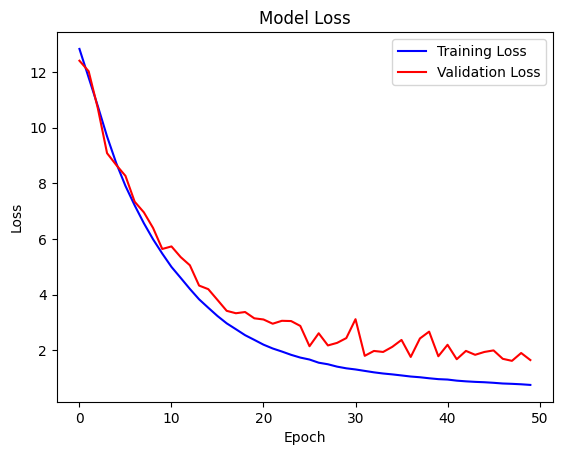

In [37]:
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()